# `numpy`部分

## 神經網路的資料表示法：張量Tensor

### 純量(0D 張量）

In [3]:
import numpy as np
x = np.array(12)
print(x)
print(x.ndim)

12
0


###  向量(1D 張量）

In [4]:
x = np.array([12, 3, 6, 14, 7])
print(x)
print(x.ndim)

[12  3  6 14  7]
1


###  矩陣(2D 張量）

In [5]:
x = np.array([[5, 78, 2, 34, 0],
        [6, 79, 3, 35, 1],
        [7, 80, 4, 36, 2]])
print(x)
print(x.ndim)

[[ 5 78  2 34  0]
 [ 6 79  3 35  1]
 [ 7 80  4 36  2]]
2


###  3D張量和高階張量

In [6]:
x = np.array([[[5, 78, 2, 34, 0],
        [6, 79, 3, 35, 1],
        [7, 80, 4, 36, 2]],
        [[5, 78, 2, 34, 0],
        [6, 79, 3, 35, 1],
        [7, 80, 4, 36, 2]],
        [[5, 78, 2, 34, 0],
        [6, 79, 3, 35, 1],
        [7, 80, 4, 36, 2]]])
print(x)
print(x.ndim)

[[[ 5 78  2 34  0]
  [ 6 79  3 35  1]
  [ 7 80  4 36  2]]

 [[ 5 78  2 34  0]
  [ 6 79  3 35  1]
  [ 7 80  4 36  2]]

 [[ 5 78  2 34  0]
  [ 6 79  3 35  1]
  [ 7 80  4 36  2]]]
3


## 圖形用張量表示
## 張量的關鍵屬性
本例使用`tf.keras`中所附的資料集`mnist`來載入資料，**注意**資料是以批次方式存在，因此shape會有60000張28x28像素的圖片，shape為(60000, 28, 28)

In [7]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [9]:
print(train_images.ndim)
print(train_images.shape)

3
(60000, 28, 28)


In [10]:
print(train_images.dtype)

uint8


**顯示第5張圖**

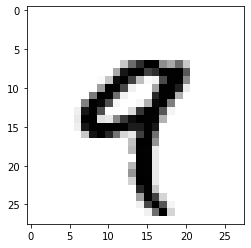

In [12]:
import matplotlib.pyplot as plt
digit = train_images[4]
plt.imshow(digit, cmap=plt.cm.binary)
plt.show()

In [13]:
train_labels[4]

9

### 在NumPy做張量切片 (Tensor Slicing)

In [14]:
my_slice = train_images[10:100]
my_slice.shape

(90, 28, 28)

In [15]:
my_slice = train_images[10:100, :, :]
my_slice.shape

(90, 28, 28)

In [16]:
my_slice = train_images[10:100, 0:28, 0:28]
my_slice.shape

(90, 28, 28)

In [23]:
my_slice = train_images[:, 14:, 14:]
print(my_slice.shape)

(60000, 14, 14)


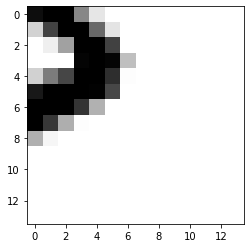

In [21]:
plt.imshow(my_slice[0], cmap=plt.cm.binary)
plt.show()

In [24]:
my_slice = train_images[:, 7:-7, 7:-7]
print(my_slice.shape)

(60000, 14, 14)


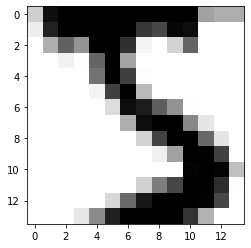

In [25]:
plt.imshow(my_slice[0], cmap=plt.cm.binary)
plt.show()

### 資料批次 (batch) 的概念

In [27]:
batch = train_images[:128]
print(batch.shape)

(128, 28, 28)


In [28]:
batch = train_images[128:256]
print(batch.shape)

(128, 28, 28)


In [29]:
n = 3
batch = train_images[128 * n:128 * (n + 1)]
print(batch.shape)

(128, 28, 28)


## 神經網路的工具：張量運算

### 逐元素的運算

### 手刻一個RELU
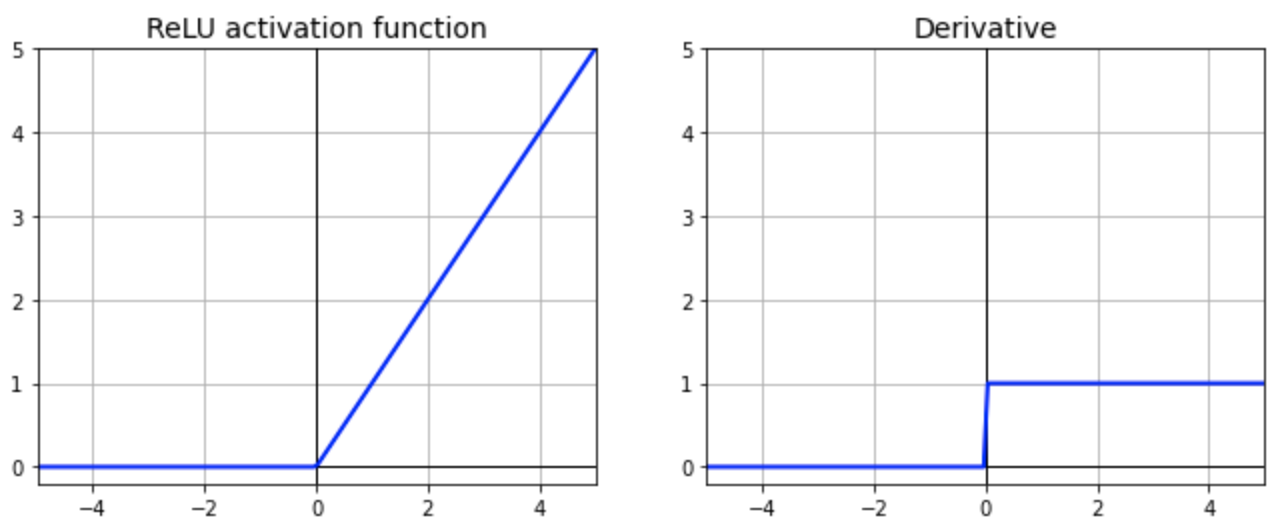

In [31]:
def naive_relu(x):
    assert len(x.shape) == 2
    x = x.copy()
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            x[i, j] = max(x[i, j], 0)
    return x
x = np.array([[1, -1, 2], [-2, 3, -3]])
print(naive_relu(x))

[[1 0 2]
 [0 3 0]]


In [34]:
def naive_add(x, y):
    assert len(x.shape) == 2
    assert x.shape == y.shape
    x = x.copy()
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            x[i, j] += y[i, j]
    return x
x = np.array([[1, -1, 2], [-2, 3, -3]])
y = np.array([[3, -2, 4], [-5, 1, -2]])
naive_add(x, y)

array([[ 4, -3,  6],
       [-7,  4, -5]])

In [41]:
import time
t0 = time.time()
for _ in range(10000):
    z = naive_add(x, y)
    z = naive_relu(z)
print("Took: {0:.2f} s".format(time.time() - t0))

Took: 10.49 s


### 用numpy建立一個relu

In [39]:
import time
import numpy as np

x = np.random.random((20, 100))
y = np.random.random((20, 100))

t0 = time.time()
for _ in range(10000):
    z = x + y
    z = np.maximum(z, 0.)
print("Took: {0:.2f} s".format(time.time() - t0))

Took: 0.02 s


### 張量擴張 (Broadcasting)

In [51]:
import numpy as np
X = np.random.random((32, 10))
y = np.random.random((10,))


(32, 10)


In [52]:
y = np.expand_dims(y, axis=0)

In [53]:
Y = np.concatenate([y] * 32, axis=0)

In [54]:
def naive_add_matrix_and_vector(x, y):
    assert len(x.shape) == 2
    assert len(y.shape) == 1
    assert x.shape[1] == y.shape[0]
    x = x.copy()
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            x[i, j] += y[j]
    return x

In [48]:
import numpy as np
x = np.random.random((64, 3, 32, 10))
y = np.random.random((32, 10))
z = np.maximum(x, y)
z.shape

(64, 3, 32, 10)

### 張量點積運算

In [ ]:
x = np.random.random((32,2))
y = np.random.random((2,16))
z = np.dot(x, y)
print(z.shape)

(32, 16)


In [ ]:
def naive_vector_dot(x, y):
    assert len(x.shape) == 1
    assert len(y.shape) == 1
    assert x.shape[0] == y.shape[0]
    z = 0.
    for i in range(x.shape[0]):
        z += x[i] * y[i]
    return z

In [ ]:
def naive_matrix_vector_dot(x, y):
    assert len(x.shape) == 2
    assert len(y.shape) == 1
    assert x.shape[1] == y.shape[0]
    z = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            z[i] += x[i, j] * y[j]
    return z

In [ ]:
def naive_matrix_vector_dot(x, y):
    z = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        z[i] = naive_vector_dot(x[i, :], y)
    return z

In [ ]:
def naive_matrix_dot(x, y):
    assert len(x.shape) == 2
    assert len(y.shape) == 2
    assert x.shape[1] == y.shape[0]
    z = np.zeros((x.shape[0], y.shape[1]))
    for i in range(x.shape[0]):
        for j in range(y.shape[1]):
            row_x = x[i, :]
            column_y = y[:, j]
            z[i, j] = naive_vector_dot(row_x, column_y)
    return z

### 張量重塑

In [56]:
train_images = train_images.reshape((60000, 28 * 28))
print(train_images.shape)

(60000, 784)


In [57]:
x = np.array([[0., 1.],
        [2., 3.],
        [4., 5.]])
x.shape

(3, 2)

In [58]:
x = x.reshape((6, 1))
x

array([[0.],
       [1.],
       [2.],
       [3.],
       [4.],
       [5.]])

In [59]:
x = np.zeros((300, 20))
x = np.transpose(x)
x.shape

(20, 300)

## 神經網路的引擎：以梯度為基礎的最佳化

### 連鎖導數：反向傳播 Backpropagation 演算法

In [66]:
import tensorflow as tf
x = tf.Variable(0.) # 實例化一個純量其初始值為0
with tf.GradientTape() as tape: # 宣告Gradient tape運作的範圍
    y = 4 * x  + 3 # 在作用範圍內對張量進行操作
    # y' = 4
grad_of_y_wrt_x = tape.gradient(y, x) # 求變數的梯度
print(grad_of_y_wrt_x.numpy()) # 輸出梯度值

4.0


In [69]:
# 在張量上操作

x = tf.Variable(tf.random.uniform((2, 2)))
print(x.shape)
with tf.GradientTape() as tape:
    y = 5 * x + 3
grad_of_y_wrt_x = tape.gradient(y, x)
print(grad_of_y_wrt_x)

(2, 2)
tf.Tensor(
[[5. 5.]
 [5. 5.]], shape=(2, 2), dtype=float32)


In [ ]:
# 進行點積操作並求gradient

W = tf.Variable(tf.random.uniform((2, 2)))
b = tf.Variable(tf.zeros((2,)))
x = tf.random.uniform((2, 2))
with tf.GradientTape() as tape:
    y = tf.matmul(x, W) + b
grad_of_y_wrt_W_and_b = tape.gradient(y, [W, b])

## 手刻一個神經網路



In [70]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype("float32") / 255

In [73]:
from tensorflow import keras
from tensorflow.keras import layers
model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])

In [78]:
model.compile(optimizer="rmsprop",
       loss="sparse_categorical_crossentropy",
       metrics=["accuracy"])

In [75]:
model.fit(train_images, train_labels, epochs=5, batch_size=128)

Epoch 1/5
469/469 [==============================] - 3s 2ms/step - loss: 0.2547 - accuracy: 0.9263
Epoch 2/5
469/469 [==============================] - 1s 1ms/step - loss: 0.1027 - accuracy: 0.9690
Epoch 3/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0674 - accuracy: 0.9796
Epoch 4/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0505 - accuracy: 0.9850
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0379 - accuracy: 0.9887


In [80]:
import numpy as np 
predictions = model(test_images)
predictions = predictions.numpy()
predicted_labels = np.argmax(predictions, axis=1)
matches = predicted_labels == test_labels
print(f"Accuracy: {matches.mean():.2f}")

Accuracy: 0.98


## 從頭開始重新建構模型

In [ ]:
import tensorflow as tf

class NaiveDense:
    def __init__(self, input_size, output_size, activation):
        self.activation = activation

        w_shape = (input_size, output_size)
        w_initial_value = tf.random.uniform(w_shape, minval=0, maxval=1e-1)
        self.W = tf.Variable(w_initial_value)

        b_shape = (output_size,)
        b_initial_value = tf.zeros(b_shape)
        self.b = tf.Variable(b_initial_value)

    def __call__(self, inputs):
        return self.activation(tf.matmul(inputs, self.W) + self.b)

    @property
    def weights(self):
        return [self.W, self.b]

In [ ]:
class NaiveSequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, inputs):
        x = inputs
        for layer in self.layers:
           x = layer(x)
        return x

    @property
    def weights(self):
       weights = []
       for layer in self.layers:
           weights += layer.weights
       return weights

In [ ]:
model = NaiveSequential([
    NaiveDense(input_size=28 * 28, output_size=512, activation=tf.nn.relu),
    NaiveDense(input_size=512, output_size=10, activation=tf.nn.softmax)
])
assert len(model.weights) == 4

In [ ]:
import math

class BatchGenerator:
    def __init__(self, images, labels, batch_size=128):
        assert len(images) == len(labels)
        self.index = 0
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.num_batches = math.ceil(len(images) / batch_size)

    def next(self):
        images = self.images[self.index : self.index + self.batch_size]
        labels = self.labels[self.index : self.index + self.batch_size]
        self.index += self.batch_size
        return images, labels

### 執行單次的訓練

In [ ]:
def one_training_step(model, images_batch, labels_batch):
    with tf.GradientTape() as tape:
        predictions = model(images_batch)
        per_sample_losses = tf.keras.losses.sparse_categorical_crossentropy(
            labels_batch, predictions)
        average_loss = tf.reduce_mean(per_sample_losses)
    gradients = tape.gradient(average_loss, model.weights)
    update_weights(gradients, model.weights)
    return average_loss

In [ ]:
learning_rate = 1e-3

def update_weights(gradients, weights):
    for g, w in zip(gradients, weights):
        w.assign_sub(g * learning_rate)

In [ ]:
from tensorflow.keras import optimizers

optimizer = optimizers.SGD(learning_rate=1e-3)

def update_weights(gradients, weights):
    optimizer.apply_gradients(zip(gradients, weights))

### 完整的訓練循環

In [ ]:
def fit(model, images, labels, epochs, batch_size=128):
    for epoch_counter in range(epochs):
        print(f"Epoch {epoch_counter}")
        batch_generator = BatchGenerator(images, labels)
        for batch_counter in range(batch_generator.num_batches):
            images_batch, labels_batch = batch_generator.next()
            loss = one_training_step(model, images_batch, labels_batch)
            if batch_counter % 100 == 0:
                print(f"loss at batch {batch_counter}: {loss:.2f}")

In [ ]:
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype("float32") / 255

fit(model, train_images, train_labels, epochs=100, batch_size=128)

Epoch 0
loss at batch 0: 0.44
loss at batch 100: 0.43
loss at batch 200: 0.38
loss at batch 300: 0.46
loss at batch 400: 0.55
Epoch 1
loss at batch 0: 0.44
loss at batch 100: 0.42
loss at batch 200: 0.37
loss at batch 300: 0.45
loss at batch 400: 0.54
Epoch 2
loss at batch 0: 0.43
loss at batch 100: 0.41
loss at batch 200: 0.36
loss at batch 300: 0.44
loss at batch 400: 0.54
Epoch 3
loss at batch 0: 0.42
loss at batch 100: 0.40
loss at batch 200: 0.35
loss at batch 300: 0.43
loss at batch 400: 0.53
Epoch 4
loss at batch 0: 0.41
loss at batch 100: 0.39
loss at batch 200: 0.35
loss at batch 300: 0.43
loss at batch 400: 0.53
Epoch 5
loss at batch 0: 0.40
loss at batch 100: 0.39
loss at batch 200: 0.34
loss at batch 300: 0.42
loss at batch 400: 0.52
Epoch 6
loss at batch 0: 0.40
loss at batch 100: 0.38
loss at batch 200: 0.33
loss at batch 300: 0.41
loss at batch 400: 0.52
Epoch 7
loss at batch 0: 0.39
loss at batch 100: 0.37
loss at batch 200: 0.33
loss at batch 300: 0.41
loss at batch 40

### 評估模型

In [76]:
import numpy as np 
predictions = model(test_images)
predictions = predictions.numpy()
predicted_labels = np.argmax(predictions, axis=1)
matches = predicted_labels == test_labels
print(f"accuracy: {matches.mean():.2f}")

accuracy: 0.98
